In [6]:
import skimage
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift, fftfreq
from skimage.feature import register_translation as phase_cross_correlation

In [7]:
def norm(A):
    return (A - A.mean())/A.std()

In [10]:
from skimage.transform import rotate
from skimage.io import imread

In [11]:
image = imread('00p700078.TIF')

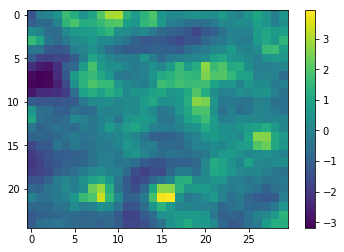

In [12]:
x, y = 450, 251
Lx, Ly = 30, 25
A = image[y:y+Ly, x:x+Lx]
dx, dy = 2, 5
image_r = image + image[:, ::-1]
B = image_r[y+dy:y+dy+Ly, x+dx:x+dx+Lx]
A = norm(A)
B = norm(B)

sigma = 0.1
B_prime = B + sigma*np.random.randn(*B.shape)

B_prime = norm(B_prime)

plt.imshow(A);
plt.colorbar();

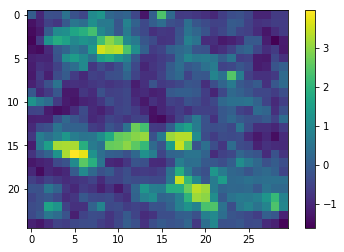

In [13]:
plt.imshow(B);
plt.colorbar();

In [14]:
upsamplefactor = 10

a, b = fftn(A.T), fftn(B.T)

ab = a * b.conj()
phase_corr = ifftn(fftshift(ab),
                   s=upsamplefactor*np.array(ab.shape))

#phase_corr = ifftn(ab)
phase_corr = np.abs( fftshift(phase_corr))

dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

# argmax
argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
print('argmax', f"{argmax}")

argmax (3.416666666666667, -8.879999999999999)


In [15]:
print('np.std(A-B)', np.std(A-B))

np.std(A-B) 1.4096378230046775


In [16]:
sigmaP = np.std(A-B)
N = phase_corr.size
#logP = N*np.log(sigmaP*np.sqrt(2*np.pi)) + N/sigmaP**2 - 1/sigmaP**2*phase_corr
logP = 1/sigmaP**2*phase_corr

p = np.exp(logP)
p = p/np.sum(p)

In [17]:

print('entropy:', np.sum( -p*logP ))
print(np.sum( p>np.max(p)/2 ))
#entropy: 1299.998
# entropy: 1111.7009203219181   10°
# entropy: 983.338944144397

entropy: -0.3882883013060947
27347


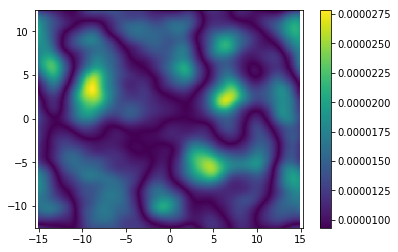

In [18]:
plt.pcolormesh(dx_span, dy_span, p);
plt.axis('equal'); plt.colorbar();

In [19]:
def sample(sigma=0.51):    
    B_prime = B + sigma*np.random.randn(*B.shape)
    shifts = phase_cross_correlation(A, B_prime, upsample_factor=50, return_error=False)
    return shifts

In [20]:
shifts = np.vstack([sample(sigma=.5) for _ in range(500)])
shifts_mean = np.mean(shifts, axis=0)
print(shifts_mean)

[-1.89832  1.45076]


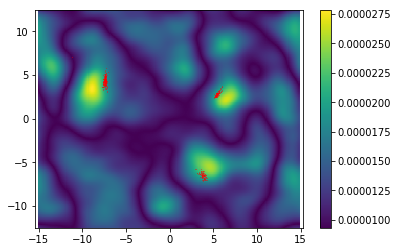

In [21]:
plt.pcolormesh(dx_span, dy_span, p);
plt.plot(*shifts.T, ',r', alpha=0.4)
plt.axis('equal'); plt.colorbar();
#plt.xlim([-5+shifts_mean[0], 5+shifts_mean[0]]);
#plt.ylim([-5+shifts_mean[1], 5+shifts_mean[1]]);

In [22]:
sigmaP

1.4096378230046775

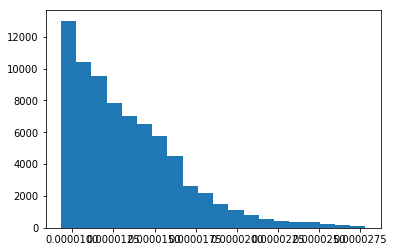

In [23]:
plt.hist(p.flatten(), bins=20);

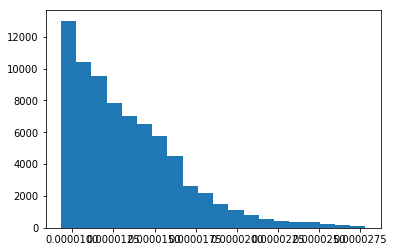

In [24]:
plt.hist(p.flatten(), bins=20);

on error estimation

1. RMS is relative, but that could be enough
but no, 
likely local minimum get above, RMS is not as good as the true min


the point is that we have the full parameter space map, at least as 1-pixel resolution,

so we have much more information available than the inverse hessian at max

question: how we use this information ?

    np.count( A>A/2 )
    
it's possible to check, using montecarlo on generated data